In [2]:
import pandas as pd

from scipy.optimize import fsolve
from openpyxl import load_workbook

import numpy as np
import uncertainties as uc

pd.options.display.float_format ='{:,.3f}'.format
import matplotlib.pyplot as plt
import matplotlib.colors as clr

%matplotlib inline  
from IPython.display import Image
from IPython.core.display import HTML 

from scipy import integrate
import scipy.stats as stats
from uncertainties import ufloat
from uncertainties import unumpy
from sklearn.linear_model import LinearRegression

from scipy.stats import gmean

%run Utility_Functions.ipynb

# Skin cells

The skin is composed of two main layers:
1. Epidermis - the outer layer. Contain tens of layers separated to 4-5 domains. Populated mostly by nucleated keratinocytes. The top 15-20 layers of cells are called Startum Corneum and are containing corneocytes, dead keratinocytes cells
2. Dermis - the inner layer. Comprise of a connective tissue. The main cells populting it are fibroblast, responsible for the secration of the extracellular matrix. 


## Skin total mass and cellualr mass
We use data summarized in [ICRP, 2002](http://www.icrp.org/publication.asp?id=ICRP%20Publication%2089) regarding the surface area and depth of the different segments of the body to determine the overall mass of the skin parts. We then use data from [Snyder et al., 1975](http://www.icrp.org/publication.asp?id=ICRP%20Publication%2023) regarding the potasium concentraion to asses the fraction of cellular mass based on a furmola from [Wang et al., 2004](https://www.ncbi.nlm.nih.gov/pubmed/14532167)

In [3]:
skin_prop_data = pd.read_excel('Skin_cells_data.xlsx','Skin_properties',index_col=0,usecols = range(0,8),skipfooter = 1)
#assigning the data including its uncertatinies to a new dataframe:
skin_prop = pd.DataFrame(index = skin_prop_data.index) 

for parmeter in ['epidermis thickness (µm)','dermal thickness (µm)','total surface area (m^2)']:
    skin_prop[parmeter] = unumpy.uarray(skin_prop_data[parmeter],skin_prop_data[parmeter +' SD'])
    
#calculating the total mass using the denisity. Translating all the length units to cm
skin_prop['epidermis total mass (g)'] = skin_prop_data['mass density (g/cm^3)'] *(skin_prop['epidermis thickness (µm)']*10**(-4))*(skin_prop['total surface area (m^2)']*10**4) 
skin_prop['dermis total mass (g)'] = skin_prop_data['mass density (g/cm^3)'] *(skin_prop['dermal thickness (µm)']*10**(-4))*(skin_prop['total surface area (m^2)']*10**4) 

#creating a data frame which indices are dermis/epidermis and contain the total mass of them
skin_part_mass=pd.DataFrame(skin_prop[['epidermis total mass (g)','dermis total mass (g)']].sum(axis=0)).rename(index={'epidermis total mass (g)':'epidermis',
                                                                                                                         'dermis total mass (g)':'dermis'}, 
                                                                                                               columns={0:'total mass (g)'})


In [7]:
#uploading the data regarding the cellular mass of the skin  
mass_data = pd.read_excel('Skin_cells_data.xlsx','Cellular_mass',index_col=0, usecols=range(6))

#assuming the variance in the estimate for the dermis and the epidermis is similiar
mass_data.loc[['Epidermis potassium','Dermis potassium'],'SD'] = mass_data.loc[['Epidermis potassium','Dermis potassium'],'value']*mass_data.loc['Whole skin potassium','SD']/mass_data.loc['Whole skin potassium','value']

# combining the values and uncertainties for computations. 
# cmdt =cellular mass data
cmdt = pd.Series(unumpy.uarray(mass_data['value'],mass_data['SD']), index =mass_data.index ) #cell mass data

#using Wang's formula to conclude the total cellular mass in each of the compartments
skin_part_mass['potassium content (g)'] = cmdt[['Epidermis potassium','Dermis potassium']].values

skin_part_mass['cellular mass (g)']= 1000*(skin_part_mass['potassium content (g)']/cmdt['potassium molar mass'])*cmdt['cell mass/potassium conc.']*1000 
#convert from mmol to mol, and the results from kg to g
skin_part_mass

,total mass (g),potassium content (g),cellular mass (g)
epidermis,121+/-20,0.46+/-0.15,(1.1+/-0.4)e+02
dermis,(3.21+/-0.31)e+03,1.1+/-0.4,(2.6+/-0.9)e+02


## Epidermal cells numbers and mass
Combining the data regarding the surface area of the body (from [ICRP, 2002](http://www.icrp.org/publication.asp?id=ICRP%20Publication%2089)) with measurements of cellular area density from [Bauer et al., 2001](https://www.ncbi.nlm.nih.gov/pubmed/11180009) and [Hoath and Leahy, 2003](https://www.sciencedirect.com/science/article/pii/S0022202X1530556X) and [Bergstresser et al., 1978](https://www.sciencedirect.com/science/article/pii/S0022202X15452534) we can get an estimate for number of the different cells in the epidermis. We also use the data regarding the prevalence of melanocytes from [Quevedo et al., 1975](https://www.ncbi.nlm.nih.gov/pubmed/1211434) to estimates their contributions.

We integrate the numbers of cells with their mean mass (taken from [Bergstresser et al., 1978](https://www.sciencedirect.com/science/article/pii/S0022202X15452534)) to get an estimate for the total cellular mass, which we can compare to the one we got from the potassium content. 

In [10]:
surface_density_data = pd.read_excel('Skin_cells_data.xlsx','Surface_density',index_col=0, usecols=range(7))

#fill in the entries of the table using the given data. Note that corneocytes aren't included in the nucleated cells.

#using the average of Bergstresser et al., 1978 and Bauer et al., 2001 estimates and calculating SEM from them.
nucSD = surface_density_data.loc['total nucelated cells','surface density cells/mm^2'].std()/np.sqrt(surface_density_data.loc['total nucelated cells'].index.size)
surface_density_data=surface_density_data.groupby('cells').mean()
surface_density_data.loc['total nucelated cells','SD']= nucSD

surface_density_data.loc['Langerhans cells','% of nucleated cells'] =surface_density_data.loc['Langerhans cells','surface density cells/mm^2']/ surface_density_data.loc['total nucelated cells','surface density cells/mm^2']
surface_density_data.loc['melanocytes',['surface density cells/mm^2','SD']] =surface_density_data.loc['melanocytes','% of nucleated cells']*surface_density_data.loc['total nucelated cells',['surface density cells/mm^2','SD']]

surface_density_data.loc['keratinocytes','% of nucleated cells'] = 1-surface_density_data.loc[['Langerhans cells','melanocytes'],'% of nucleated cells'].sum(axis=0) 
surface_density_data.loc['keratinocytes',['surface density cells/mm^2','SD']] = surface_density_data.loc['keratinocytes','% of nucleated cells']*surface_density_data.loc['total nucelated cells',['surface density cells/mm^2','SD']]
surface_density_data.loc['corneocytes','SD'] = surface_density_data.loc['corneocytes','surface density cells/mm^2']*surface_density_data.loc['total nucelated cells','SD']/surface_density_data.loc['total nucelated cells','surface density cells/mm^2']


#combining the values with the error for further computations
surface_density_data['density + error (cells/mm^2)'] = unumpy.uarray(surface_density_data['surface density cells/mm^2'],surface_density_data['SD'])
surface_density_data['total cells'] = skin_prop['total surface area (m^2)'].sum(axis=0)*10**6*surface_density_data['density + error (cells/mm^2)']  #usingt the total surface area and translating m^2 to mm^2

#extracting the mean celllar mass of nucleated and corneocytes, according to Bergstresser et al., 1978 data
nuc_cell_mass = ufloat(mass_data.loc['nucleated cell volume','value'],mass_data.loc['nucleated cell volume','SD'])*1.05 #assuming density of 1.05g/cm^3 as for other cells. results in pg.
cor_cell_mass = ufloat(mass_data.loc['corneocytes cell volume','value'],mass_data.loc['corneocytes cell volume','SD'])*1.05 

#using the mean mass to compute the total mass of each of the cell type
surface_density_data['cellular mass']=0
surface_density_data.loc[surface_density_data['nucleated']==1,'cellular mass'] = nuc_cell_mass*surface_density_data.loc[surface_density_data['nucleated']==1,'total cells']/10**12 #translating pg to grams
surface_density_data.loc['corneocytes','cellular mass'] = cor_cell_mass*surface_density_data.loc['corneocytes','total cells']/10**12


print('Number of total epidermal nucleated cells: {:0.1eP}'.format(surface_density_data.loc['total nucelated cells','total cells']))
print('Average mass of epidermal nucleated cells: {:0.0fP} pg'.format(nuc_cell_mass))

print('____ _____ _____')

print('Total cellular mass of epidermal nucleated cells based on number estimate: {:0.0fP} g'.format(surface_density_data.loc['total nucelated cells','cellular mass']))
print('Total cellular mass of epidermal cells based on number estimate (including corneocytes): {:0.0fP} g'.format(surface_density_data.loc[['total nucelated cells','corneocytes'],
                                                                                                                                         'cellular mass'].sum(axis=0)))
print('Total cellular mass of the epidermis based potassium content: {:0.0fP} g'.format(skin_part_mass.loc['epidermis','cellular mass (g)']),
      'out of total mass of {:0.0fP} g'.format(skin_part_mass.loc['epidermis','total mass (g)']))



Number of total epidermal nucleated cells: (1.2±0.3)×10¹¹
Average mass of epidermal nucleated cells: 830±32 pg
____ _____ _____
Total cellular mass of epidermal nucleated cells based on number estimate: 97±22 g
Total cellular mass of epidermal cells based on number estimate (including corneocytes): 139±24 g
Total cellular mass of the epidermis based potassium content: 108±38 g out of total mass of 121±20 g


The two estimates for the cellular mass overlap, as they should. 

As kertinocytes dominant the cell population we focus on them. As corneocytes are essentially dead cells, we don't count them.

saving the results for future extraction.
:

In [6]:
skin_results = pd.DataFrame(index = ['Epidermal cells', 'Dermal fibroblasts'],
                      columns=['number','lifespan','cellular turnovr rate','cell mass','cellular mass turnovr rate','total cellular mass'])

skin_results.loc['Epidermal cells','number'] = surface_density_data.loc['total nucelated cells','total cells']
skin_results.loc['Epidermal cells','cell mass'] = nuc_cell_mass
skin_results.loc['Epidermal cells','total cellular mass'] = surface_density_data.loc['total nucelated cells','cellular mass']

## Epidermal cells turnover
The lifespan of keratinocytes was estimated by integration of labeling measurement with modeling of the turnover through three distinguish compartments in the epidermis:
1. The germinative cell layer - the basal layer in which the cells are being produced.
2. The overlying viable epidermis - the layers in which the keratinocytes are still viable.
3. The Startum Corneum - the layers at the top that contain only dead cells (corneocytes)

We are interested in the lifespan that include only the viable compartments - e.g the first two.

During the 1970's-1980's several studies used estimates for the duration of the DNA synthesis (S-phase) and labeling indices, and the relation of cell density in them to estimate the turnover through the three compartments [Halprin, 1972](https://www.ncbi.nlm.nih.gov/pubmed/4551262), [Bergstresser and Taylor, 1977](https://www.ncbi.nlm.nih.gov/pubmed/871385), [Weinstein et al., 1984](https://www.ncbi.nlm.nih.gov/pubmed/6725985). We look at their values for the turnover and use the average of the main values as our reference.


Text(0.5, 0, 'epidermal cells')

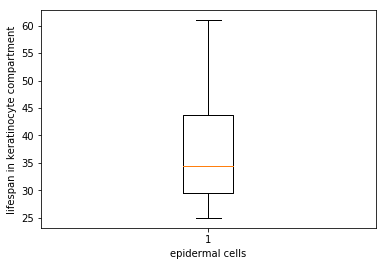

In [7]:
epi_to_data = pd.read_excel('Skin_cells_data.xlsx','epidermal_turnoevr',index_col=0, usecols=range(7))

#showing using boxplot
plt.boxplot(epi_to_data['keratinocyte compartment'])
plt.ylabel('lifespan in keratinocyte compartment')
plt.xlabel('epidermal cells')

As it easy to see, Halprin maximal estiamtes is very high relative to the other and therfore we remove it and calcaulate the average and standard error without it.
Using the lifespan and previous estimate we compute the total turnover rates:

In [8]:
skin_results.loc['Epidermal cells','lifespan'] = ufloat(epi_to_data.loc[epi_to_data['description']!='maximal','keratinocyte compartment'].mean(),
                                                        epi_to_data.loc[epi_to_data['description']!='maximal','keratinocyte compartment'].std()/np.sqrt(epi_to_data.loc[epi_to_data['description']!='maximal','keratinocyte compartment'].size))

#turnover = number/mass divided by the lifespan
skin_results.loc['Epidermal cells','cellular turnovr rate'] = skin_results.loc['Epidermal cells','number']/skin_results.loc['Epidermal cells','lifespan']
skin_results.loc['Epidermal cells','cellular mass turnovr rate'] = skin_results.loc['Epidermal cells','total cellular mass']/skin_results.loc['Epidermal cells','lifespan']


#using for loop to print the overall estimates.
units = ['days','cells per day','grams per day']
formats = ['{:0.0fP}','{:0.1eP}','{:0.1fP}']
parameters =['lifespan','cellular turnovr rate','cellular mass turnovr rate']

for i,param in enumerate(parameters):
    print(param.capitalize() + ' of epidermal cells:'+ formats[i].format(skin_results.loc['Epidermal cells',param])+ ' '+units[i])
      

Lifespan of epidermal cells:31±4 days
Cellular turnovr rate of epidermal cells:(3.7±0.9)×10⁹ cells per day
Cellular mass turnovr rate of epidermal cells:3.1±0.8 grams per day


## Dermal fibroblast

Estimated to be 0.1% of the cells in the body. They are responsible for the secreting of the dermal extracellular matrix.

### Dermal fibroblast numbers and mass
Repeating the estimates made in [Sender et al., 2016](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.1002533) we use the cellular density in two parts of the dermis: papillary  and reticular.
Multiplying data regarding cellular density in the layers [Randolph and Simon, 1998](https://www.ncbi.nlm.nih.gov/pubmed/9740244), [Miller  et al., 2003](https://www.ncbi.nlm.nih.gov/pubmed/12930296)  with the general data regarding the surfcace area and thickness of the skin and the fraction of the two parts [McGrath et al., 2004](https://onlinelibrary.wiley.com/doi/10.1002/9781444317633.ch3)

In [9]:
derm_fib_data = pd.read_excel('Skin_cells_data.xlsx','dermal_fib_data',index_col=0, usecols=range(6))
derm_fib_data.head()

skin_prop['pap der thick'] = skin_prop['dermal thickness (µm)']* ufloat(derm_fib_data.loc['papillary dermis portion','value'],derm_fib_data.loc['papillary dermis portion','SD'])
skin_prop['ret der thick'] = skin_prop['dermal thickness (µm)']* ufloat(derm_fib_data.loc['reticular dermis portion','value'],derm_fib_data.loc['reticular dermis portion','SD'])

ret_den= ufloat(derm_fib_data.loc['mid dermis fibroblast density/skin unit volume','value'],derm_fib_data.loc['mid dermis fibroblast density/skin unit volume','SD'])
cv_ret = derm_fib_data.loc['mid dermis fibroblast density/skin unit volume','SD']/derm_fib_data.loc['mid dermis fibroblast density/skin unit volume','value']
#assuming similar fraction of uncertainty (CV)
pap_den = ufloat(derm_fib_data.loc['papillary fibroblast density/skin unit volume','value'],
                 derm_fib_data.loc['papillary fibroblast density/skin unit volume','value']*cv_ret)

#using the SA, depth and density to estimate the total number
skin_prop['papillary fibroblast'] = skin_prop['pap der thick']*skin_prop['total surface area (m^2)']*pap_den 
skin_prop['reticular fibroblast'] = skin_prop['ret der thick']*skin_prop['total surface area (m^2)']*ret_den 

#summing the numbers and saving it in the results:

dr_fib_num  = skin_prop['papillary fibroblast'].sum() + skin_prop['reticular fibroblast'].sum()


#we can asses the error as a multiplication factor

# dr_fib_num_unc = gmean([1+dr_fib_num .std_dev/dr_fib_num.nominal_value,1/(1-dr_fib_num.std_dev/dr_fib_num .nominal_value)])
dr_fib_num_unc = AddErr2MulF(dr_fib_num)

skin_results.loc['Dermal fibroblasts','number'] = dr_fib_num.nominal_value , dr_fib_num_unc

print('Total number of dermal fibroblasts: {:0.1e},'.format(skin_results.loc['Dermal fibroblasts','number'][0]),
     'SD range: {:0.0e} - '.format(skin_results.loc['Dermal fibroblasts','number'][0]/skin_results.loc['Dermal fibroblasts','number'][1]),
    '{:0.0e} cells'.format(skin_results.loc['Dermal fibroblasts','number'][0]*skin_results.loc['Dermal fibroblasts','number'][1])) 

#assumin density of 1.05 and using the data from Mitsui  and Schneider, 1976
fib_mass =  1.05 *ufloat(derm_fib_data.loc['fibroblast volume','value'], derm_fib_data.loc['fibroblast volume','SD'])

#converting the uncertainty to terms of multpilication factor
fib_mass_unc =AddErr2MulF(fib_mass) # gmean([1+fib_mass.std_dev/fib_mass.nominal_value,1/(1-fib_mass.std_dev/fib_mass.nominal_value)])
  
skin_results.loc['Dermal fibroblasts','cell mass'] = round(fib_mass.nominal_value,-1) , fib_mass_unc

print('The mass of a dermal fibroblasts is: {:0.0f} pg,'.format(skin_results.loc['Dermal fibroblasts','cell mass'][0]),
     'SD range: {:0.0f} - '.format(round(skin_results.loc['Dermal fibroblasts','cell mass'][0]/skin_results.loc['Dermal fibroblasts','cell mass'][1],-2)),
    '{:0.0f} pg'.format(round(skin_results.loc['Dermal fibroblasts','cell mass'][0]*skin_results.loc['Dermal fibroblasts','cell mass'][1],-2))) 


total_fib_mass = fib_mass.nominal_value*dr_fib_num.nominal_value/10**12
#using the 'FacMulProp' utility function defined in the designated notebook to propogate the uncertiatny given as  multiplication factor
total_fib_mass_unc = FacMulProp([dr_fib_num_unc,fib_mass_unc]) 

print('The total cellular mass of a dermal fibroblasts is: {:0.0f} grams'.format(total_fib_mass),
     'SD range: {:0.0f} - '.format(total_fib_mass/total_fib_mass_unc),
    '{:0.0f} grams'.format(total_fib_mass*total_fib_mass_unc)) 


skin_results.loc['Dermal fibroblasts','total cellular mass'] = total_fib_mass,total_fib_mass_unc


Total number of dermal fibroblasts: 3.8e+10, SD range: 2e+10 -  6e+10 cells
The mass of a dermal fibroblasts is: 2270 pg, SD range: 2100 -  2500 pg
The total cellular mass of a dermal fibroblasts is: 87 grams SD range: 55 -  138 grams


### Dermal Fibroblast turnover

There is no direct measurment of the lifespan of human dermal fibroblast in-vivo , only irrelevant data from in-vitro expermints.
We therfore use the known data measured in mouse ([Ruchti et al., 1983](https://www.ncbi.nlm.nih.gov/pubmed/6883461)) and deduce for human dermal fobroblast using the power law regeression made in the Mouse comparison notebook.

In [11]:
#importing the power law regression from the mouse comparison notebook
%run Mouse_comparison.ipynb

mouse_fib_ls_unc = AddErr2MulF(derm_fib_data.loc['mouse dermal fibroblast lifespan','value'],derm_fib_data.loc['mouse dermal fibroblast lifespan','SD'])
mouse_fib_ls = derm_fib_data.loc['mouse dermal fibroblast lifespan','value'],mouse_fib_ls_unc

#using the function PowerPred to get prediction for the lifespan of dermal fibroblast in human, and its uncertainty.
skin_results.loc['Dermal fibroblasts','lifespan'] = tuple(Pred_With_Unc([mouse_fib_ls])[0])

print('Predicted lifespan of human dermal fibrobalst: {:0.0f} days,'.format(round(skin_results.loc['Dermal fibroblasts','lifespan'][0],-1)),
      'SD range: {:0.0f} - '.format(round(skin_results.loc['Dermal fibroblasts','lifespan'][0]/skin_results.loc['Dermal fibroblasts','lifespan'][1],-1)),
      '{:0.0f} days'.format(round(skin_results.loc['Dermal fibroblasts','lifespan'][0]*skin_results.loc['Dermal fibroblasts','lifespan'][1],-1)))

dr_fib_to = skin_results.loc['Dermal fibroblasts','number'][0]/skin_results.loc['Dermal fibroblasts','lifespan'][0]
#using the 'FacMulProp' utility function defined in the designated notebook to propogate the uncertiatny given as  multiplication factor
dr_fib_to_unc = FacMulProp([skin_results.loc['Dermal fibroblasts','number'][1],skin_results.loc['Dermal fibroblasts','lifespan'][1]]) 


print('Total cellular turnover rate  of dermal fibroblasts: {:0.1e} cells per day,'.format(dr_fib_to),
     'SD range: {:0.0e} - '.format(dr_fib_to/dr_fib_to_unc),
    '{:0.0e} cells per day'.format(dr_fib_to*dr_fib_to_unc)) 


skin_results.loc['Dermal fibroblasts','cellular turnovr rate'] =  dr_fib_to ,dr_fib_to_unc


dr_fib_mass_to = skin_results.loc['Dermal fibroblasts','total cellular mass'][0]/skin_results.loc['Dermal fibroblasts','lifespan'][0]
#using the 'FacMulProp' utility function defined in the designated notebook to propogate the uncertiatny given as  multiplication factor
dr_fib_mass_to_unc= FacMulProp([skin_results.loc['Dermal fibroblasts','total cellular mass'][1],skin_results.loc['Dermal fibroblasts','lifespan'][1]])

print('Total cellular mass turnover rate of fibroblasts: {:0.1f} grams per day,'.format(dr_fib_mass_to),
     'SD range: {:0.2f} - '.format(dr_fib_mass_to/dr_fib_mass_to_unc),
    '{:0.1f} grams per day'.format(dr_fib_mass_to*dr_fib_mass_to_unc)) 


skin_results.loc['Dermal fibroblasts','cellular mass turnovr rate'] = dr_fib_mass_to,dr_fib_mass_to_unc


Predicted lifespan of human dermal fibrobalst: 880 days, SD range: 660 -  1170 days
Total cellular turnover rate  of dermal fibroblasts: 4.4e+07 cells per day, SD range: 3e+07 -  7e+07 cells per day
Total cellular mass turnover rate of fibroblasts: 0.1 grams per day, SD range: 0.06 -  0.2 grams per day


## Saving the results to excell
For further use

In [113]:
to_excell =pd.DataFrame(index = range(6), columns=['Parameter','Value','Units','Uncertainty','Comments']) 

to_excell['Parameter'] =  pd.Series(skin_results.columns)
to_excell['Units'] = pd.Series(['Cells','days','cells per day','pg','grams per day', 'grams'])

file = 'Summary.xlsx'
book = load_workbook(file)
writer = pd.ExcelWriter(file, engine = 'openpyxl')
writer.book = book

writer.sheets = dict((ws.title, ws) for ws in book.worksheets)
sheet=writer.book.active
    
#we go through the types of cells and for each we arrange the results in a dataframe for extracting to excel.
#we check for the type of error (linear or multiplicle) and extract the uncertainty accordingly 
for cell in skin_results.index:
    if(isinstance(skin_results.loc[cell,'number'],tuple)):
        to_excell['Value'] = pd.Series([val for val,unc in skin_results.loc[cell]])
        to_excell['Uncertainty'] = pd.Series([unc for val,unc in skin_results.loc[cell]])
        to_excell['Comments'] = pd.Series(['uncertainty by multiplication factor' for val,unc in skin_results.loc[cell]])
        
    elif(isinstance(skin_results.loc[cell,'number'],uc.UFloat)):
        to_excell['Value'] =pd.Series(unumpy.nominal_values(skin_results.loc[cell]))
        to_excell['Uncertainty'] = pd.Series(unumpy.std_devs(skin_results.loc[cell]))
        to_excell['Comments'] = pd.Series(['linear uncertainty' for c in skin_results.loc[cell]])

    to_excell.to_excel(writer, sheet_name = cell,index=False)
    worksheet = writer.sheets[cell]   
#     using the colors defined in the color sheet to color the tabs. Using the extraction of the data in the Utility_Functions.ipynb notebook
    worksheet.sheet_properties.tabColor= colors_data.loc[cell,'hex'] 
    writer.save()
    